# Load modules and define function(s)

In [1]:
import sys
from tqdm.auto import tqdm
sys.path.append('../code/')
import source
import importlib
importlib.reload(source)
from source.catalog import CatalogASCII
from source.skymap import PlanckMap
from source import map_params
import healpy as hp
import numpy as np
import astropy.units as au

import matplotlib
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)


# Plot clusters on healpix map
def plot_clusters(ra, dec):
    """
    Plots clusters overlaid on top of cmb map
    """
    hp.graticule()
    hp.projscatter(ra.to_value(au.deg), dec.to_value(au.deg), lonlat=True, c='r', marker='o', alpha=0.25)

## Project a square patch from the Planck HFI143GHz map, centered on a bright Blazar

Map unit changed from K to muK
3.665 deg
128


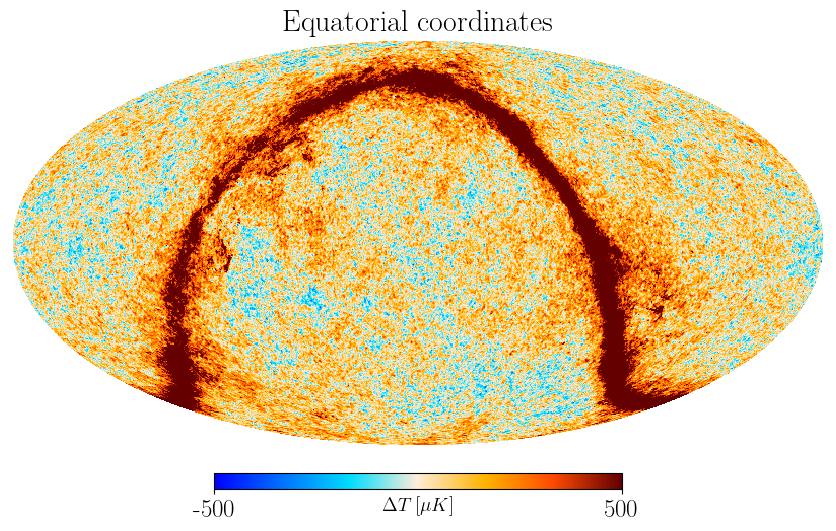

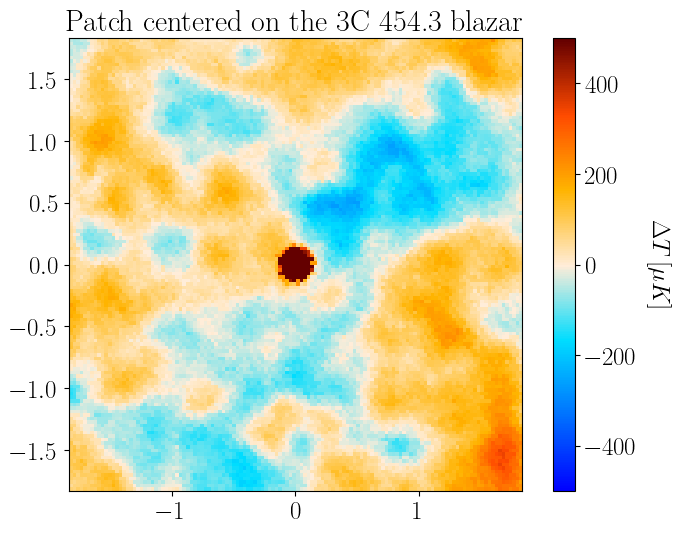

In [2]:
# Load HFI 143GHz cmb map without mask
cmb_name = '../data/cmb/observed_map/HFI_SkyMap_143_2048_R3.01_full.fits'
cmb_map = PlanckMap(mapFile=cmb_name,maskFile=None)
cmb_map.rotate(coord=['G','C'],alms=False)
hp.mollview(cmb_map.map,min=-500.,max=500.,cmap=cmb_map.cmap,title='Equatorial coordinates',unit=r'$\Delta T\,[\mu K]$')

# Cartesian projection of test CMB map centered around blazar 3C 454.3
ra=343.490616 * au.deg
dec=16.148211 * au.deg
size = map_params.patch_size
print(size)
n_pixels=int(map_params.n_pixels)
print(n_pixels)
patch = cmb_map.get_Cartesian_square_patch(ra,dec,
            patch_size=size,n_pixels=n_pixels,return_proj=False)

# Plot the cutout
fig, ax = plt.subplots(1)
im=ax.imshow(patch, origin='lower',interpolation='None',cmap=cmb_map.cmap,norm=matplotlib.colors.Normalize(vmin=-500.,vmax=500.),
             extent=[-size.to_value(au.deg)/2., size.to_value(au.deg)/2., -size.to_value(au.deg)/2., size.to_value(au.deg)/2.])
plt.title(r'Patch centered on the 3C 454.3 blazar')
cbar=fig.colorbar(im, orientation='vertical')
cbar.set_label("$\Delta T\,[\mu K]$", rotation=-90, va="bottom")
plt.show()

## Stack Planck HFI143GHz map at positions of maxBCG clusters

Map unit changed from K to muK
Total number of clusters loaded:
2189


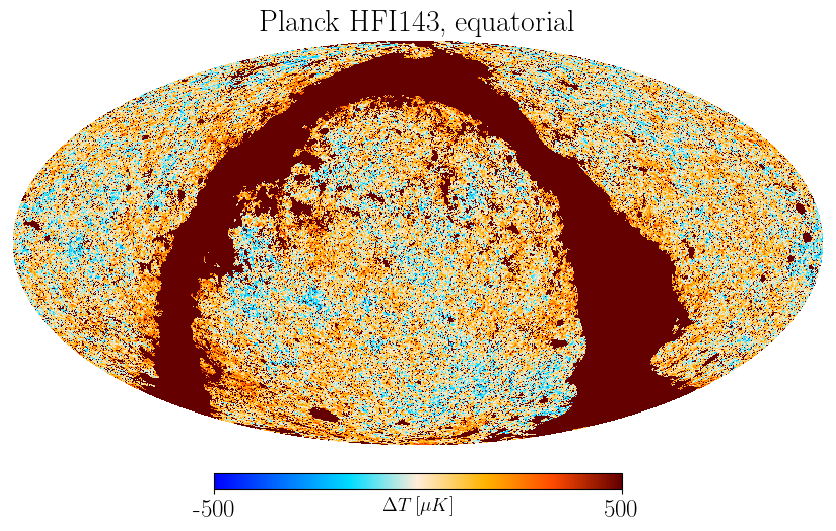

In [3]:
## Load HFI 143GHz cmb map with mask

cmb_name = '../data/cmb/observed_map/HFI_SkyMap_143_2048_R3.01_full.fits'
mask_name = '../data/cmb/survey_mask/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits' # common mask
cmb_map = PlanckMap(mapFile=cmb_name,maskFile=mask_name)
extra_mask_name = '../data/cmb/survey_mask/COM_CompMap_Compton-SZMap-PSmask_2048_R2.01.fits' # Planck y-map PS mask
cmb_map.combine_mask(extra_mask_name)
cmb_map.rotate(coord=['G','C'],alms=False)
hp.mollview(cmb_map.map,min=-500.,max=500.,cmap=cmb_map.cmap,title='Planck HFI143, equatorial',unit=r'$\Delta T\,[\mu K]$')

## Load clusters

catFile='../data/cluster/maxBCG_ID_redshift_sky_selected.dat'
cat = CatalogASCII(catFile,use_photoz=False,specz_col=3,N200_col=4)

ID = cat.id
z = cat.specz
ra = cat.coord.ra
dec = cat.coord.dec
N200 = cat.N200
N_cluster = len(N200)
print("Total number of clusters loaded:")
print(N_cluster)


# Project out square patches - maxBCG

In [4]:
## Setup the projection

size = map_params.patch_size
n_pixels=int(map_params.n_pixels)
patches=[]
removed=[]
badval= hp.UNSEEN
#cmb_map.map[np.where(cmb_map.map.mask==True)] = 0. # set masked pixels to 0. before projecting
#cmb_map.map[np.where(np.abs(cmb_map.map)>1e20)] = 0. # set too cold/hot pixels to 0. before projecting

## Loop through clusters, project out a square patche centered around each

for i in tqdm(range(len(ra)), total=len(ra)):
    patch = cmb_map.get_Cartesian_square_patch(ra[i],dec[i],
                    patch_size=size,
                    n_pixels=n_pixels,
                    return_proj=False)
    ### Patches whose masked pixels are more than 20% of total pixels are removed
    if ((np.isclose(patch,badval)).sum()/len(patch.ravel())<=0.2):
        patch[np.isclose(patch,badval)]=0.
        patches.append(patch)
    else:
        removed.append(i)
patches = np.asarray(patches)
test_patch = '../data/test_cmb_patches_HFI143_maxBCG.npy'
np.save(test_patch, patches)

  0%|          | 0/2189 [00:00<?, ?it/s]

# Stack projected patches - maxBCG

In [5]:
from source.skymap import PlanckMap, SquarePatch
stacked_patches = SquarePatch(patch_array=patches[0,:,:])
for i in tqdm(range(patches.shape[0]-1),total=patches.shape[0]-1):
    patch = SquarePatch(patch_array=patches[i+1,:,:])
    stacked_patches.stack(map2=patch.map)
stacked_patches.map /= patches.shape[0]
print("Min temperature in stacked map:")
print(stacked_patches.map.min())
print("Max temperature in stacked map:")
print(stacked_patches.map.max())
print("Mean temperature in stacked map:")
print(stacked_patches.map.mean())
print("Std of temperature in stacked map:")
print(stacked_patches.map.std())

  0%|          | 0/2052 [00:00<?, ?it/s]

Min temperature in stacked map:
25.189582050306093
Max temperature in stacked map:
34.846323589275535
Mean temperature in stacked map:
29.349757906245102
Std of temperature in stacked map:
1.734910586898917


# Plot example patches and stacked patch - maxBCG

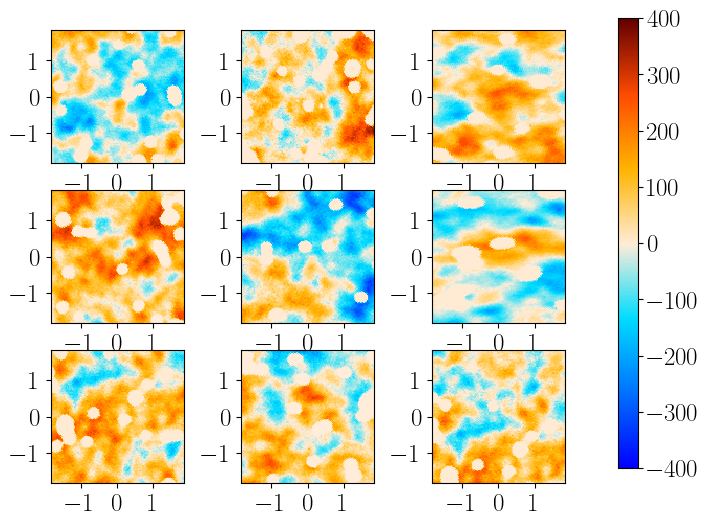

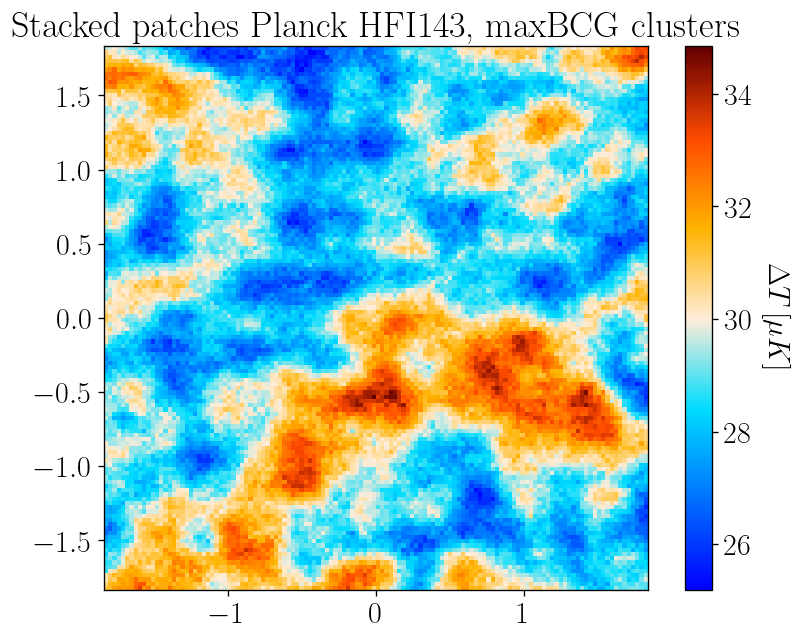

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3,dpi=100)
for i, ax in enumerate(axes.flat):
    im=ax.imshow(patches[i,:,:],origin='lower',interpolation='None',cmap=cmb_map.cmap,extent=[-size.to_value(au.deg)/2., size.to_value(au.deg)/2., -size.to_value(au.deg)/2., size.to_value(au.deg)/2.],vmin=-400.,vmax=400.)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.75])
fig.colorbar(im, cax=cbar_ax)
#cbar_ax.set_label("$\Delta T\,[\mu K]$", rotation=-90, va="bottom")
plt.show()
fig, ax = plt.subplots(1,1,dpi=120)
im=ax.imshow(stacked_patches.map,origin='lower',interpolation='None',cmap=cmb_map.cmap,extent=[-size.to_value(au.deg)/2., size.to_value(au.deg)/2., -size.to_value(au.deg)/2., size.to_value(au.deg)/2.])
plt.title(r'Stacked patches Planck HFI143, maxBCG clusters')
cbar=fig.colorbar(im, orientation='vertical')
cbar.set_label("$\Delta T\,[\mu K]$", rotation=-90, va="bottom")
plt.show()

## Stack Planck HFI143GHz at positions of Planck SZ-Union clusters

Map unit changed from K to muK
Total number of clusters (no data-cut yet):
1653


0.0 180.0 -180.0 180.0


Total number of clusters after mask cut:
1119


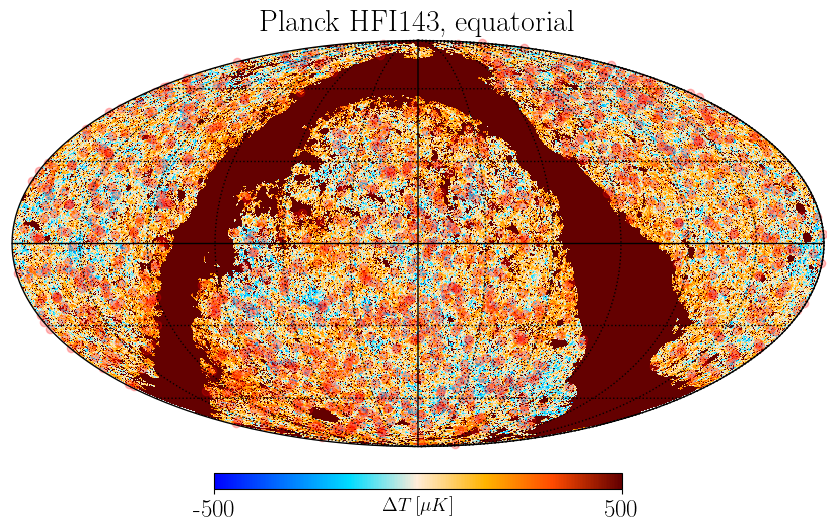

In [7]:
## Load HFI 143GHz cmb map with mask

cmb_name = '../data/cmb/observed_map/HFI_SkyMap_143_2048_R3.01_full.fits'
mask_name = '../data/cmb/survey_mask/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits'
cmb_map = PlanckMap(mapFile=cmb_name,maskFile=mask_name)
extra_mask_name = '../data/cmb/survey_mask/COM_CompMap_Compton-SZMap-PSmask_2048_R2.01.fits' # Planck y-map PS mask
cmb_map.combine_mask(extra_mask_name)
cmb_map.rotate(coord=['G','C'],alms=False)
hp.mollview(cmb_map.map,min=-500.,max=500.,cmap=cmb_map.cmap,title='Planck HFI143, equatorial',unit=r'$\Delta T\,[\mu K]$')

## Load Planck SZ clusters

from astropy.io import fits
catFile='../../CLUSTER_cat/Planck/HFI_PCCS_SZ-union_R2.08.fits'
with fits.open(catFile) as hdul:
    hdr=hdul[1].header
    data=hdul[1].data
ra = data['RA']*au.deg
dec = data['DEC']*au.deg
N_cluster=ra.shape[0]
print("Total number of clusters (no data-cut yet):")
print(N_cluster)

## Sky cut

mask = hp.read_map(mask_name)
r = hp.Rotator(coord=['G','C'])
mask = r.rotate_map_pixel(mask)
uncut_pix = hp.ang2pix(cmb_map.nside,ra.to_value(au.deg),dec.to_value(au.deg),lonlat=True)
skycut = np.where(cmb_map.map.mask[uncut_pix]==False)
ra = ra[skycut]
dec = dec[skycut]
N_cluster = ra.shape[0]
print("Total number of clusters after mask cut:")
print(N_cluster)
plot_clusters(ra,dec)
plt.show()

# Project out square patches - Planck SZ-Union

In [8]:
## Setup the projection

patches=[]
removed=[]

## Loop through clusters, project out a square patche centered around each

for i in tqdm(range(len(ra)), total=len(ra)):
    patch = cmb_map.get_Cartesian_square_patch(ra[i],dec[i],
                    patch_size=size,
                    n_pixels=n_pixels,
                    return_proj=False)
    ### Same criterion as for maxBCG
    if ((np.isclose(patch,badval)).sum()/len(patch.ravel())<=0.2):
        patch[np.isclose(patch,badval)]=0.
        patches.append(patch)
    else:
        removed.append(i)
patches = np.asarray(patches)
test_patch = '../data/test_cmb_patches_HFI143_Planck_SZ-Union.npy'
np.save(test_patch, patches)

  0%|          | 0/1119 [00:00<?, ?it/s]

# Stack projected patches - Planck SZ-Union

In [9]:
stacked_patches = SquarePatch(patch_array=patches[0,:,:])
for i in tqdm(range(patches.shape[0]-1),total=patches.shape[0]-1):
    patch = SquarePatch(patch_array=patches[i+1,:,:])
    stacked_patches.stack(map2=patch.map)
stacked_patches.map /= patches.shape[0]
print("Min temperature in stacked map:")
print(stacked_patches.map.min())
print("Max temperature in stacked map:")
print(stacked_patches.map.max())
print("Mean temperature in stacked map:")
print(stacked_patches.map.mean())
print("Std of temperature in stacked map:")
print(stacked_patches.map.std())

  0%|          | 0/952 [00:00<?, ?it/s]

Min temperature in stacked map:
12.594602175279578
Max temperature in stacked map:
49.07015464752407
Mean temperature in stacked map:
38.73873712801307
Std of temperature in stacked map:
2.8852181665167578


# Plot stacked patch - Planck SZ-Union

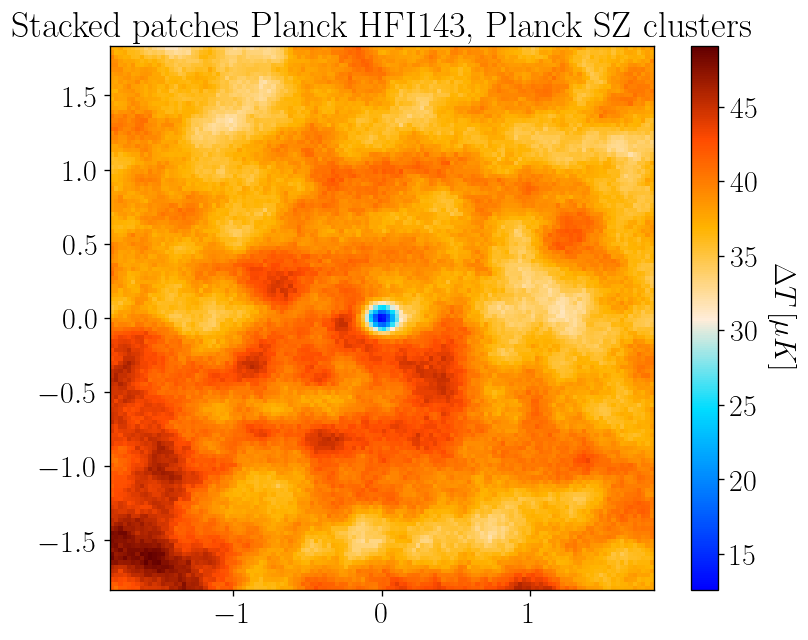

In [10]:
fig, ax = plt.subplots(1,dpi=120)
im=ax.imshow(stacked_patches.map,origin='lower',interpolation='None',cmap=cmb_map.cmap,extent=[-size.to_value(au.deg)/2., size.to_value(au.deg)/2., -size.to_value(au.deg)/2., size.to_value(au.deg)/2.])
plt.title(r'Stacked patches Planck HFI143, Planck SZ clusters')
cbar=fig.colorbar(im, orientation='vertical')
cbar.set_label("$\Delta T\,[\mu K]$", rotation=-90, va="bottom")
plt.show()

###### 